## Clustering and PCA on Chicago West Nile Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

### Import data

In [2]:
path = '/Users/michaelshea/desktop/class/WestNile/WestNilePrediction/Assets/merged.csv'

In [3]:
merged = pd.read_csv(path)

In [4]:
merged['Date'] = pd.to_datetime(merged.Date)

In [5]:
merged.set_index('Date', inplace=True)

### Cluster with DBScan

Set columns for cluster analysis; limiting to a few for simplicity

In [84]:
merged.columns

Index([u'Trap', u'Latitude', u'Longitude', u'NumMosquitos', u'WnvPresent',
       u'Month', u'Year', u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       u'Species_CULEX SALINARIUS', u'Species_CULEX TARSALIS',
       u'Species_CULEX TERRITANS', u'Station', u'Tmax', u'Tmin', u'Tavg',
       u'DewPoint', u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset',
       u'PrecipTotal', u'StnPressure', u'SeaLevel', u'ResultSpeed',
       u'ResultDir', u'AvgSpeed', u'date_station_id', u'prev_day_precip'],
      dtype='object')

In [7]:
cols_for_cluster = ['NumMosquitos', 'Month', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 
                   'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Tavg', 
                    'PrecipTotal', 'Tmax', 'Tmin', 'DewPoint', 'prev_day_precip']

In [8]:
merged_cluster = merged[cols_for_cluster]

In [9]:
db = DBSCAN(eps=1, min_samples=40)

In [10]:
db.fit(merged_cluster)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    min_samples=40, p=None, random_state=None)

In [11]:
db.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [12]:
np.unique(db.labels_)

array([-1,  0,  1,  2])

Add cluster labels as column to dataframe

In [13]:
merged['cluster'] = db.labels_

Group by clusters and observe any trends

In [14]:
grouped_cluster = merged.groupby('cluster').mean()

There are five clusters:

In [15]:
grouped_cluster.shape

(4, 30)

Plot clusters

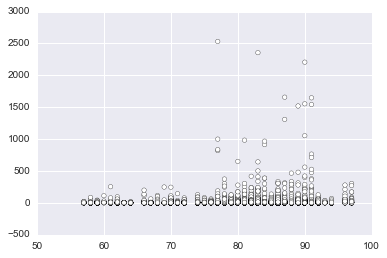

In [16]:
plt.scatter(merged.Tmax, merged.NumMosquitos, c=[merged.cluster])

### PCA

In [95]:
merged.columns

Index([u'Trap', u'Latitude', u'Longitude', u'NumMosquitos', u'WnvPresent',
       u'Month', u'Year', u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       u'Species_CULEX SALINARIUS', u'Species_CULEX TARSALIS',
       u'Species_CULEX TERRITANS', u'Station', u'Tmax', u'Tmin', u'Tavg',
       u'DewPoint', u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset',
       u'PrecipTotal', u'StnPressure', u'SeaLevel', u'ResultSpeed',
       u'ResultDir', u'AvgSpeed', u'date_station_id', u'prev_day_precip',
       u'cluster'],
      dtype='object')

In [17]:
cols_for_pca = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 
                'PrecipTotal', 'ResultSpeed', 'AvgSpeed', 'ResultDir', 'StnPressure',
               'prev_day_precip']

In [18]:
X = merged[cols_for_pca]

In [19]:
xStand = StandardScaler().fit_transform(X)

In [20]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [21]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

6.26030501577
2.24964850884
1.33684848971
0.965947673583
0.792917506589
0.509574919971
0.473957177489
0.214349896917
0.111175859069
0.0797944779486
0.00597137007221
0.0010432083683
8.08888289627e-16


In [22]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [23]:
print(varExpl)


[48.150510282362788, 17.302946642954929, 10.282236534437818, 7.4294899804326171, 6.09864574615953, 3.9193445625909042, 3.645394256444809, 1.6486508068755124, 0.85509800749008003, 0.61373125131534711, 0.045928196044382932, 0.0080237328912828951, -6.2214834275442228e-15]


In [24]:
cvarex = np.cumsum(varExpl)

In [25]:
print(cvarex)

[  48.15051028   65.45345693   75.73569346   83.16518344   89.26382919
   93.18317375   96.82856801   98.47721881   99.33231682   99.94604807
   99.99197627  100.          100.        ]


90% of the variance is explained by the first five components.

In [26]:
pcask = PCA(n_components=5)
Y = pcask.fit_transform(xStand)

In [27]:
Ydf = pd.DataFrame(Y)

### Logistic Regression

Conduct Logistic Regression with five principal components plus Latitude', u'Longitude', u'NumMosquitos', month and mosquito species.

In [30]:
Ydf['Latitude'] = merged.Latitude.values
Ydf['Longitude'] = merged.Longitude.values
Ydf['NumMosquitos'] = merged.NumMosquitos.values
Ydf['erraticus'] = merged['Species_CULEX ERRATICUS'].values
Ydf['pipiens'] = merged['Species_CULEX PIPIENS'].values
Ydf['pip_rest'] = merged['Species_CULEX PIPIENS/RESTUANS'].values
Ydf['restuans'] = merged['Species_CULEX RESTUANS'].values
Ydf['salinarius'] = merged['Species_CULEX SALINARIUS'].values
Ydf['tarsalis'] = merged['Species_CULEX TARSALIS'].values
Ydf['territans'] = merged['Species_CULEX TERRITANS'].values
Ydf['month'] = merged.Month.values
Ydf['cluster'] = db.labels_
Ydf['pre_day_precip'] = merged.prev_day_precip.values

In [31]:
logreg = LogisticRegression()

Reimport merged dataframe to get targets (they were dropped earlier)

In [34]:
merged_2 = pd.read_csv(path)
merged_2['Date'] = pd.to_datetime(merged_2.Date)
merged_2.set_index('Date', inplace=True)

In [35]:
X = Ydf
y = merged_2.WnvPresent

In [36]:
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
pred_class = cross_val_predict(logreg, X, y)

In [38]:
merged_2['Predictions'] = logreg.predict(X)

In [39]:
print metrics.accuracy_score(y, pred_class)

0.946666666667


In [40]:
print metrics.confusion_matrix(y, pred_class)

[[7998   20]
 [ 432   25]]


In [41]:
print metrics.recall_score(y, pred_class)

0.054704595186


In [42]:
print metrics.precision_score(y, pred_class)

0.555555555556


To compute area under ROC curve, need to use a train test split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, stratify = y)

In [44]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
y_prob = logreg.predict_proba(X_test)[:,1]

In [46]:
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_prob, 0.2)[0]

/Users/michaelshea/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [47]:
y_pred_class

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [48]:
print metrics.recall_score(y_test, y_pred_class)

0.105263157895


In [49]:
print metrics.precision_score(y_test, y_pred_class)

0.444444444444


In [50]:
print metrics.accuracy_score(y_test, y_pred_class)

0.944785276074


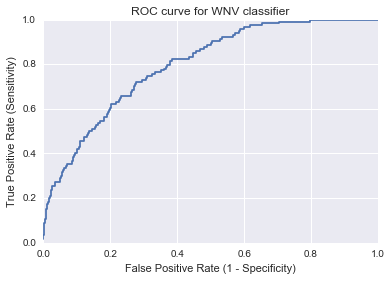

In [51]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for WNV classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [52]:
print metrics.roc_auc_score(y_test, y_prob)

0.796893730586


In [57]:
merged['pred_wnv'] = pred_class

In [60]:
merged.to_csv('../Assets/tableau_test.csv')

### KNN

In [ ]:
# search for an optimal value of K for KNN
k_range = range(1, 50)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores

In [ ]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
print cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()

In [ ]:
y_pred = cross_val_predict(knn, X, y, cv=10)

In [ ]:
print metrics.recall_score(y, y_pred)

In [ ]:
print metrics.precision_score(y, y_pred)

#### Conduct a Random Forest Classifier on PCA

In [ ]:
from sklearn.cross_validation import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
metrics.recall_score(y_test, y_pred)

In [ ]:
metrics.precision_score(y_test, y_pred)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

In [ ]:
metrics.confusion_matrix(y_test, y_pred)